# Машинное обучение, DS-поток
## Задание ML.5


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

* Задача 1 &mdash; 10 баллов;
* Задача 2 &mdash; 10 баллов;
* Задача 3 &mdash; 30 баллов;
* Задача 4 &mdash; 10 баллов;
* Задача 5 &mdash; 90 баллов.

In [4]:
# Bot check

# HW_ID: ds_ml5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm
import time


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

---
## Теория

Рассмотрим задачу бинарной классификации, причем $\mathscr{Y} = \{+1, -1\}$. Пусть так же $\widehat{y}$ &mdash; некоторый классификатор, предсказывающий <u><i>степень принадлежности</i></u> классу. При этом решающее правило имеет вид 
 $f(x) = \text{sign}\left(\widehat{y}(x)\right)$.
В задачах 1-4 рассматриваем логистическую функцию потерь:
$$\mathcal{L}(y, z) = \log \big(1 + \exp(-yz) \big).$$

### Задача 1

Покажите, что задача минимизации по функциям $y(x)$ функционала ошибки $$Q(y) = \sum\limits_{i = 1}^n \mathcal{L}\left(Y_i, y(x_i)\right) \longrightarrow \min_{y(x)}$$ для логистической функции потерь эквивалентна максимизации по $y(x)$ функции правдоподобия в предположении $Y_i \sim Bern(\sigma(y(x_i)))$, где $Y_i \in \{-1, +1 \}$.

Заметим, что
$$\mathbb P_y(Y_i = t) = \mathbb P(Y_i = t) = \left( \frac{1}{1 + \exp(-y(x_i))} \right)^{\frac{1+t}{2}} \left(1 - \frac{1}{1 + \exp(-y(x_i))} \right)^{\frac{1-t}{2}}, t \in \{-1, 1\}  $$

Тогда функция правдоподобия примет вид:

$$\prod_{i=1}^n \left( \frac{1}{1 + \exp(-y(x_i))} \right)^{\frac{1+Y_i}{2}} \left(1 - \frac{1}{1 + \exp(-y(x_i))} \right)^{\frac{1-Y_i}{2}}$$

А ее логарифм:

$$\sum_{i=1}^{n}  \frac{1+Y_i}{2} \log \left( \frac{1}{1 + \exp(-y(x_i))} \right) + \frac{1-Y_i}{2} \left(1 - \frac{1}{1 + \exp(-y(x_i))} \right) $$

При $Y_i = 1~i-\text{е}$ слагаемое имеет вид:

$$-\log(1 + \exp(-y(x_i) \cdot 1) = -\log\left(1 + \exp(-y(x_i) \cdot Y_i)\right)$$

При $Y_i = -1$:

$$\log \left( \frac{\exp(-y(x_i))}{1 + \exp(-y(x_i))} \right) = \log \left( \frac{1}{1 + \exp(y(x_i))} \right) = -\log(1 + \exp(-y(x_i) \cdot (-1)) = -\log\left(1 + \exp(-y(x_i) \cdot Y_i)\right)$$ 

Откуда максимизация функции правдоподобия сводится к максимизации 
$$\sum_{i=1}^{n}-\log\left(1 + \exp(-y(x_i) \cdot Y_i)\right) = \sum_{i=1}^{n} - \mathcal{L}\left(Y_i, y(x_i)\right)$$
А это ровно и есть минимизация функционала ошибки
$$Q(y) = \sum\limits_{i = 1}^n \mathcal{L}\left(Y_i, y(x_i)\right) \longrightarrow \min_{y(x)}$$

### Задача 2

Рассмотрим градиентный бустинг с логистической функцией потерь. Выпишите для градиентного спуска формулу для вектора сдвигов предсказаний и задачу поиска новой базовой модели по их приближению. 

Текущий классификатор $\hat y$ дает лосс:
$$Q(\hat y) = \sum\limits_{i = 1}^n \mathcal{L}\left(Y_i, \hat y(x_i)\right) = \sum_{i=1}^{n}\log\left(1 + \exp(-\hat y(x_i) \cdot Y_i)\right)$$

Мы должны минимизировать потери:
$$b = \text{argmin}_{b \in \beta} \sum\limits_{i = 1}^n \mathcal{L}\left(Y_i, \hat y(x_i) + b(x_i)\right)$$

И новый классификатор примет вид

$$y'(x) = \hat y(x) + b(x)$$

$b$ находим по первому члену разложения в ряд Тейлора:

$$\sum\limits_{i = 1}^n \mathcal{L}\left(Y_i, \hat y(x_i) + b(x_i)\right) = \sum\limits_{i = 1}^n \left[\mathcal{L}\left(Y_i, \hat y(x_i)\right) + b(x_i) \frac{\partial L\left(Y_i, \hat y(x_i)\right)}{\partial \hat y(x_i)} \right]$$

То есть $b(x_i)$ должен предсказывать $-\frac{\partial L\left(Y_i, \hat y(x_i)\right)}{\partial \hat y(x_i)}$

Градиент лосса по предсказанию:

$$\frac{\partial L\left(Y_i, \hat y(x_i)\right)}{\partial \hat y(x_i)} = \frac{\exp(-\hat y(x_i) \cdot Y_i) (-Y_i)}{1 + \exp(-\hat y(x_i) Y_i)}= - \frac{Y_i}{1 + \exp(\hat y(x_i) \cdot Y_i)}$$

**Итого**:

Задача поиска новой модели задает сдвиги предсказаний ($\beta$ - множество классификаторов):

$$b = \text{argmin}_{b \in \beta} \sum\limits_{i = 1}^n \mathcal{L}\left(\frac{Y_i}{1+\exp(\hat y(x_i) \cdot Y_i)}, b(x_i)\right)$$

И новый классификатор $y'$ пересчитывается от старого $\hat y$ по правилу:

$$y'(x) = \hat y(x) + b(x)$$


### Задача 3

Предположим, модель градиентного бустинга $\widehat{y}_{t - 1}$ уже построена.
1. Выпишите вид функционала ошибки $Q(\widehat{y}_t) = \sum\limits_{i = 1}^n \mathcal{L}\left(Y_i, \widehat{y}_t(x_i)\right)$ для логистической функции потерь. Одинаковый ли вклад вносят разные объекты в ошибку при построении новой базовой модели $b_t$?
2. Посмотрите на формулу для вектора сдвигов, полученную в предыдущей задаче. Как она выражается через отклики на объектах обучающей выборки? Одинаковый ли вклад вносят разные объекты в формирование вектора сдвигов при построении новой базовой модели $b_t$?
3.  На лекции было показано, что для экспоненциальной функции есть проблема: базовый классификатор может настраиваться только на шумовые объекты. Наблюдается ли такая проблема у логистической функции потерь? Как она ведет себя на объектах с сильно отрицательным, околонулевым, сильно положительным отсупами?

1) Функционал:
 $$Q(\widehat{y}_t) = \sum\limits_{i = 1}^n \mathcal{L}\left(Y_i, \widehat{y}_t(x_i)\right) = \sum_{i=1}^{n}\log\left(1 + \exp(-\hat y_t(x_i) \cdot Y_i)\right)$$

То есть вклад в ошибку тем меньше, чем меньше значение $\exp(-\hat y(x_i) \cdot Y_i)$, то есть чем больше $\hat y_t(x_i) \cdot Y_i$. Значит, если предсказание более точное, то его вклад в ошибку будет меньше, чем для менее точных ( $\hat y_t(x_i)$ должна быть того же знака, что и $Y_i$, причем как можно больше по модулю). Таким образом, вклад неодинаковый.

2) Совершенно аналогичные рассуждения работают и для антиградиента ошибок:

$$-\frac{\partial L\left(Y_i, \hat y(x_i)\right)}{\partial \hat y(x_i)} = \frac{Y_i}{1 + \exp(\hat y(x_i) \cdot Y_i)}$$

А значит и при обучении очереденой базовой моедели $b_t$. Таким образом, вклад неодинаковый.

3)
   $$\mathcal{L}(Y_i, \hat y(x_i)) = \log \big(1 + \exp(-Y_i \cdot y(x_i)) \big)$$
  1) Шум соответствует отрицательному сдвигу (модель предсказывает плохо): $Y_i \hat y(x_i) \ll 0$
     
     В этом случае лосс не будет сильно большим (будет расти только линейно, а не экспоненциально), за счет сглаживания логарифмом 
     $$\log \left( 1 + \exp(-Y_i \hat y(x_i)) \right) \sim \log (\exp(-Y_i \hat y(x_i)) \sim -Y_i \hat y(x_i)$$

  2) Околонулевой сдвиг: $Y_i \hat y(x_i) \sim 0$:

     $$\log \left( 1 + \exp(-Y_i y(x_i)) \right) \sim \log (1 + 1) \sim \log(2)$$

     То есть некоторая константа, несколько большая нуля. Модель все еще не уверена в предсказания

  3) Сильноположительный сдвиг: $Y_i \hat y(x_i) \gg 0$:
      $$\log \left( 1 + \exp(-Y_i y(x_i)) \right) \sim \log 1 \sim 0$$

     Что и ожидаемо, модель уверена в предсказании, лосс маленький.

Таким образом, логистическая функция потерь сглаживает выбросы, и они не могут так сильно повлиять на модель.

### Задача 4

Рассмотрим градиентный бустинг над решающими деревьями с логистической функции потерь. После построения дерева будем делать перенастройку в листьях дерева.
1. Выпишите оптимизационную задачу для коэффициентов $\gamma_{tj}$ &mdash; новых ответов в листьях.
2. Решите полученную задачу сделав один шаг метода Ньютона из начального приближения $\gamma_{tj} = 0$, что соответствует отсутствию базовой модели $b_t$.


Пусть к $j$-му листу дерева $b_t$ относятся объекты $Y_{k}, k \in J$

Тогда нам нужно минимизировать функционал ошибки в $j$-м листе

$$Q(\gamma) = \sum\limits_{k \in J} \mathcal{L}\left(Y_k, \hat y_{t - 1}(x_k) + \gamma \right) = \sum\limits_{k \in J} \log\left(1 + \exp(-[\hat y_{t - 1}(x_k) + \gamma] \cdot Y_k)\right) \longrightarrow \min_{\gamma}$$
И сама оптимизационная задача 

$$\gamma_{tj} = \text{argmin}_{\gamma} \sum\limits_{k \in J} \mathcal{L}\left(Y_k, \hat y_{t - 1}(x_k) + \gamma \right)$$


Один шаг метода Ньютона:

$$f(\theta) = 0 \Rightarrow \hat \theta = \theta_0 - \frac{f(\theta_0)}{f'(\theta_0)}$$

В нашем же случае $$\frac{d Q}{d \gamma} = 0$$

Откуда метод Ньютона даст:

$$\gamma_{tj} = - \frac{Q'(0)}{Q''(0)}$$


$$\frac{d Q}{d \gamma} = \sum\limits_{k \in J} \frac{\partial \mathcal{L}\left(Y_k, \hat y_{t - 1}(x_k) + \gamma \right)}{\partial \gamma} = -\sum\limits_{k \in J} \frac{Y_k}{1 + \exp([\hat y_{t - 1}(x_k) + \gamma] \cdot Y_k))} \Rightarrow Q'(0) = -\sum\limits_{k \in J} \frac{Y_k}{1 + \exp(\hat y_{t - 1}(x_k) \cdot Y_k))}$$

$$\frac{d^2Q}{d \gamma^2} = \sum_{k \in J} \frac{Y_k^2 \exp([\hat y_{t-1}(x_k) + \gamma] \cdot Y_k)}{(1 + \exp([\hat y_{t-1}(x_k) + \gamma] \cdot Y_k)^2} \rightarrow Q''(0) = \sum_{k \in J} \frac{Y_k^2 \exp(\hat y_{t-1}(x_k) \cdot Y_k)}{(1 + \exp(\hat y_{t-1}(x_k) \cdot Y_k)^2}$$

И итоговое решение:

$$\gamma_{tj} = \sum\limits_{k \in J} \frac{Y_k}{1 + \exp(\hat y_{t - 1}(x_k) \cdot Y_k))} \bigg/ \sum_{k \in J} \frac{Y_k^2 \exp(\hat y_{t-1}(x_k) \cdot Y_k)}{(1 + \exp(\hat y_{t-1}(x_k) \cdot Y_k)^2}$$



---
## Практика

### Задача 5

**Внимание!** 

Перед выполнением задачи прочитайте полностью условие. В задаче используются смеси различных моделей с разными гиперпараметрами. Подумайте над тем, какой гиперпараметр как подбирать и на каком множестве. Не забудьте, что на тестовой выборке, по которой делаются итоговые выводы, ничего не должно обучаться.

**Не забывайте делать выводы в каждом пункте!**

#### 1.

Повторите исследование, проведенное в задаче 2 задания ML.4, используя градиентный бустинг из `sklearn`. Сравните полученные результаты со случайным лесом. 

Вкратце опишем задания:
1. Посмотрите, как меняется качество модели в зависимости от значений гиперпараметров и сделайте выводы по результатам. Гиперпараметры:
    * количество деревьев (`n_estimators`) [от 1 до 400];
    * максимальная глубина дерева (`max_depth`) [от 1 до 15];
    * скорость обучения (`learning_rate`), поясните также смысл этого параметра.
2. Запустите модель три раза с параметрами по-умолчанию. Объясните результаты.
3. Подберите оптимальные гиперпараметры, рассмотренные в первом пункте и зафиксируйте их.
4. Исследуйте зависимость метрики от количества признаков, по которым происходит разбиение в вершине дерева. Объясните результаты.

*Замечания.*
* В качестве основы можно использовать как свое решение задания ML.4, так и выложенное на [сайте](https://thetahat.ru). В большинстве случаев нужно только заменить `RandomForestRegressor` на `GradientBoostingRegressor`.
* При сравнении методов по одинаковым свойствам желательно рисовать результаты на одном графике.
* Обратите внимание на метод `staged_predict` у `GradientBoostingRegressor`. Он позволяет получить "кумулятивные" предсказания, то есть по первым $t$ деревьям по всем значениям $t$.
* При желании, границы рассмотрения значений гиперпараметров можно увеличить.
* При подборе гиперпараметров при помощи рандомизированного поиска проводите достаточное количество итераций на большой сетке параметров &mdash; как минимум 50. Даже если долго обучается.

Скачаем датасет и разделим на тестовую и тренировочную выборки и стандартизируем их

In [8]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=17
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Функция для построения графиков

In [9]:
def plot_dependence_test(param_grid, test_values, param_label,
                         metrics_label, title):
    '''
    Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра модели на валидационной выборке.
    
    Параметры.
    1) param_grid — значения исследуемого параметра,
    2) test_values — значения метрики на валидационной выборке,
    3) param_label — названия параметра,
    4) metrics_label — название метрики,
    5) title — заголовок для графика.
    '''
    
    plt.figure(figsize=(12, 6))
    plt.plot(param_grid, test_values, label='test', linewidth=3)
   
    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.legend()
    plt.title(title)
    plt.show()

Посмотрим как зависит MSE от n_estimators

In [10]:
regressor = GradientBoostingRegressor(n_estimators=400, random_state=42)
regressor.fit(X_train, y_train)

predictions = np.array(list(regressor.staged_predict(X_test)))

mse_values = [mse(y_test, p) for p in predictions]

n_estimators_grid = np.arange(1, len(mse_values) + 1)


График

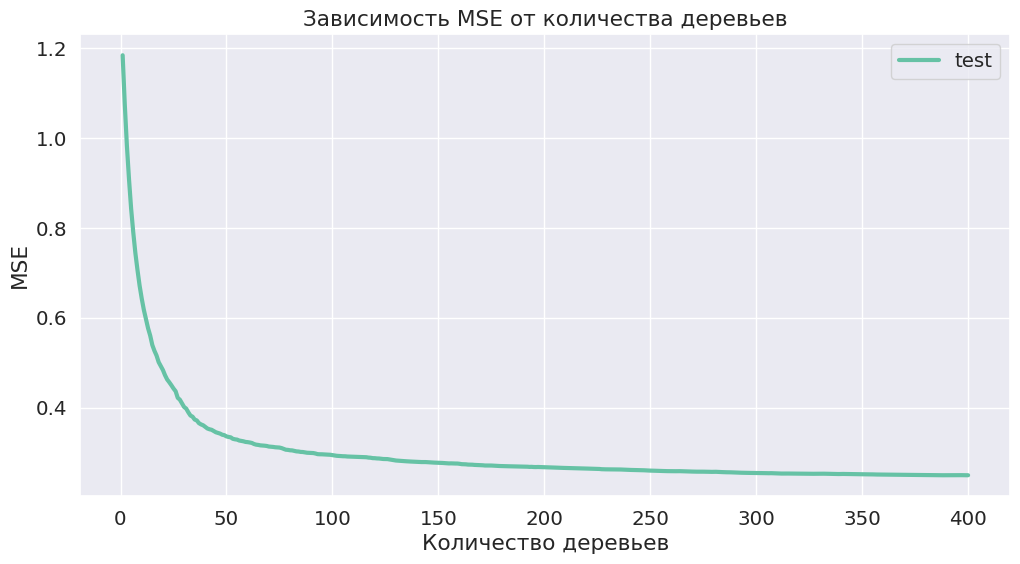

In [11]:
plot_dependence_test(n_estimators_grid, mse_values, 
                     'Количество деревьев', 'MSE', 
                     'Зависимость MSE от количества деревьев')

**Как видно, с ростом числа деревьев переобучения не наблюдается, однако начиная с около 100 деревьев выигрыша выигрыш становится намного меньше, а обучение модели становится сложнее с ростом числа деревьев**

Теперь MSE от глубины дерева

In [12]:
mse_values = []
max_depth_grid = range(1, 16)

for max_depth in tqdm(max_depth_grid):
    regressor = GradientBoostingRegressor(max_depth=max_depth, 
                                          n_estimators=50, random_state=42)
    regressor.fit(X_train, y_train)
    
    predictions = np.array(list(regressor.staged_predict(X_test)))
    
    mse_values.append(mse(y_test, predictions[-1]))



100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [01:03<00:00,  4.25s/it]


И сам график

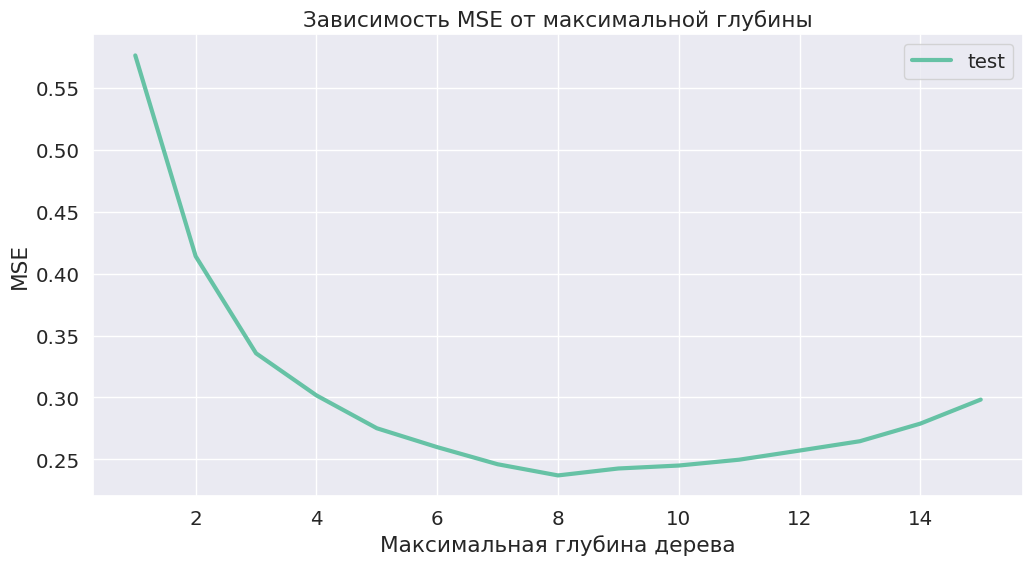

In [13]:
plot_dependence_test(max_depth_grid, mse_values, 
                     'Максимальная глубина дерева', 'MSE', 
                     'Зависимость MSE от максимальной глубины')

**Для слишком глубоких деревьев начинается переобучение, такого например не наблюдалось в случайном лесе**

Теперь MSE от learning rate

In [14]:
mse_values = []
learning_rate_grid = np.linspace(0.1, 1, 10)

for learning_rate in tqdm(learning_rate_grid):
    regressor = GradientBoostingRegressor(learning_rate=learning_rate, 
                                          n_estimators=50, random_state=42)
    regressor.fit(X_train, y_train)
    
    predictions = np.array(list(regressor.staged_predict(X_test)))
    
    mse_values.append(mse(y_test, predictions[-1]))


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


И сам график

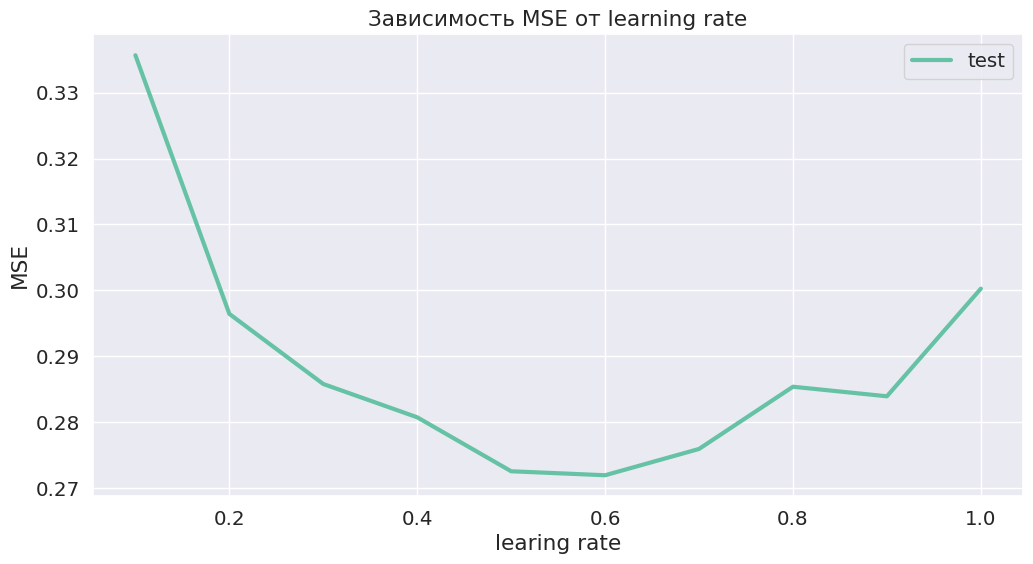

In [15]:
plot_dependence_test(learning_rate_grid, mse_values, 
                     'learing rate', 'MSE', 
                     'Зависимость MSE от learning rate')

**Learning rate $\eta$ работает так:**

На очередном шаге обучения новая модель получается через обучение базовой $b^t$ так:
$$\hat y^t(x) = \hat y^{t-1} + \eta \cdot b^t(x)$$

При меньшем $\eta$ можно избежать переобучения при слишком сложных базовых моделях, однако потребуется больше итераций для обучения.

In [16]:
for iteration in range(3):
    regressor = GradientBoostingRegressor(n_estimators=100)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    print('MSE = {:.4f}'.format(mse(y_test, predictions)))



MSE = 0.2940
MSE = 0.2940
MSE = 0.2940


**Модель в целом довольно детерминирована, поэтому MSE от запуска к запуску не изменяется, в отличие от случайного леса**

Подберем гиперпараметры

In [17]:
gb_gridsearch = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42), 
    param_distributions={
        'max_depth': np.arange(1, 15), 
        'n_estimators': [100, 300, 500],
        'learning_rate': np.linspace(0.1, 1, 15)
        
    },
    scoring='neg_mean_squared_error',  # оптимизируемый скор
    cv=3,  # разбиение выборки на 5 фолдов
    verbose=1,  # насколько часто печатать сообщения
    n_jobs=-1,  # кол-во параллельных процессов
    n_iter=300,  # кол-во итераций случайного выбора гиперпараметров
    random_state=0  # seed для фиксации генератора случайных чисел
)

gb_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


/home/juequ/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1       , 0.16428571, 0.22857143, 0.29285714, 0.35714286,
       0.42142857, 0.48571429, 0.55      , 0.61428571, 0.67857143,
       0.74285714, 0.80714286, 0.87142857, 0.93571429, 1.        ]),
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': [100, 300, 500]},
                   random_state=0, scoring='neg_mean_squared_error', verbose=1)

Лучшие параметры

In [18]:
print(gb_gridsearch.best_params_)

{'n_estimators': 500, 'max_depth': np.int64(5), 'learning_rate': np.float64(0.1)}


Запомним их

In [19]:
gb_max_depth = gb_gridsearch.best_params_['max_depth']
gb_n_estimators = gb_gridsearch.best_params_['n_estimators']
gb_learning_rate = gb_gridsearch.best_params_['learning_rate']

MSE на тестовой выборке для лучшей модели

In [20]:
predictions = gb_gridsearch.best_estimator_.predict(X_test)
print('{:.4f}'.format(mse(y_test, predictions)))

0.2235


Подсчет зависимости MSE от числа признаков n_features, по которым происходит разбиение в вершине дерева:

In [21]:
mse_train_values = []
mse_test_values = []

for n_features in range(1, 9):
    rf_regressor = GradientBoostingRegressor(
        max_depth=gb_max_depth, n_estimators=gb_n_estimators, 
        max_features=n_features, learning_rate=gb_learning_rate, random_state=42
    )
    rf_regressor.fit(X_train, y_train)
    
    current_train_mse = mse(y_train, rf_regressor.predict(X_train))
    current_test_mse = mse(y_test, rf_regressor.predict(X_test))
    print('n_features: {}, train_mse: {:.4f}, test_mse: {:.4f}'.format(
        n_features, current_train_mse, current_test_mse
    ))
    
    mse_train_values.append(current_train_mse)
    mse_test_values.append(current_test_mse)

n_features: 1, train_mse: 0.1095, test_mse: 0.2491
n_features: 2, train_mse: 0.0853, test_mse: 0.2246
n_features: 3, train_mse: 0.0788, test_mse: 0.2217
n_features: 4, train_mse: 0.0749, test_mse: 0.2207
n_features: 5, train_mse: 0.0742, test_mse: 0.2276
n_features: 6, train_mse: 0.0731, test_mse: 0.2248
n_features: 7, train_mse: 0.0723, test_mse: 0.2250
n_features: 8, train_mse: 0.0730, test_mse: 0.2235


Функция для построения графика

In [22]:
def plot_dependence(param_grid, train_values, test_values, 
                    param_label='', metrics_label='', title='',
                    train_label='train (GradientBoosting)', 
                    test_label='test (GradientBoosting)', 
                    create_figure=True):
    '''
    Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра модели на обучающей и на валидационной 
    выборке.
    
    Параметры.
    1) param_grid — значения исследуемого параметра,
    2) train_values — значения метрики на обучающей выборке,
    3) test_values — значения метрики на валидационной выборке,
    4) param_label — названия параметра,
    5) metrics_label — название метрики,
    6) title — заголовок для графика,
    7) create_figure — флаг, устанавливающий нужно ли создавать 
    новую фигуру для графика.
    '''
    
    if create_figure:
        plt.figure(figsize=(12, 6))
    plt.plot(param_grid, train_values, label=train_label, linewidth=3)
    plt.plot(param_grid, test_values, label=test_label, linewidth=3)
       
    plt.legend()
    if create_figure:
        plt.xlabel(param_label)
        plt.ylabel(metrics_label)
        plt.title(title, fontsize=20)


И сам график

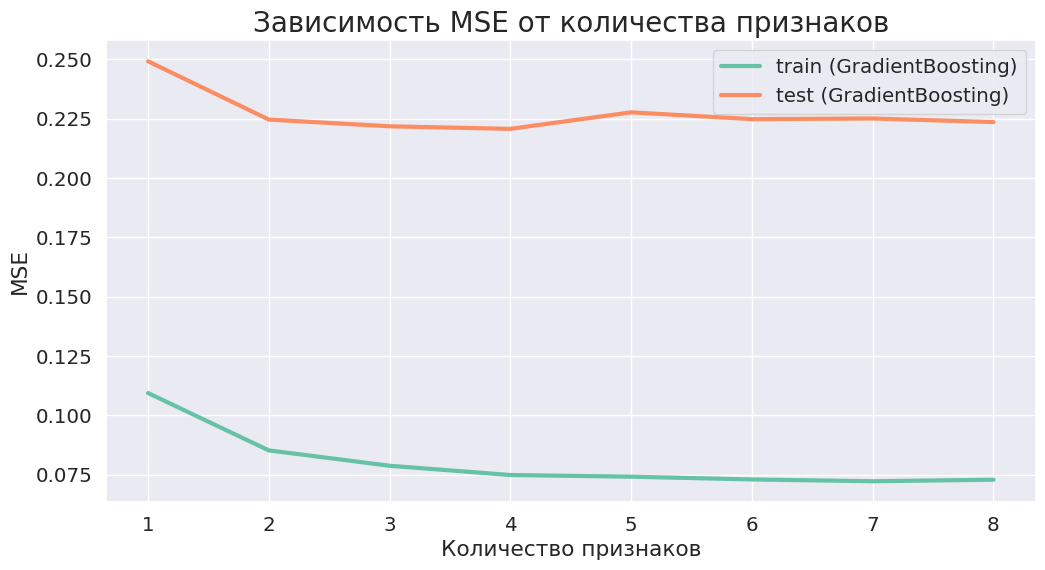

In [23]:
plot_dependence(range(1, 9), mse_train_values, mse_test_values, 
                'Количество признаков', 'MSE', 
                'Зависимость MSE от количества признаков')

**Чем больше признаков, тем лучше качество получаемой модели, что логично. Однако, качество растет не так быстро, потому что n_features работает для каждой базовой модели, а их много (на каждом шаге просто оптимизируется ошибка вдоль меньшего числа признаков). Маленькое значение делает модель более простой и устойчивой к переобучению**

Для подбора гиперпараметров нужно использовать методы валидации

**2.**

Проведите сравнение случайного леса и градиентного бустинга с оптимальными гиперпараметрами, подобранными ранее, по производительности, в рамках которого выполните следующие действия.
* Замерьте время обучения данных моделей.
* Замерьте время построения предсказания для каждого объекта тестовой выборки. Постройте гистограмму, посчитайте среднее время и предсказательный интервал (возьмите выборочные квантили).
* Сравните фактическую глубину деревьев и количество листьев в композициях с помощью гистограмм. Посчитайте также среднее значение указанных характеристик. Используйте методы `get_depth()` и `get_n_leaves()` у решающего дерева.

Оптимальные параметры для случайного леста из ML_4:

In [24]:
rf_max_depth = 26
rf_n_estimators = 226

Обучим 10 раз каждую модель и возьмем среднее от времен обучения и построим ДИ для времен обученя и через квантили

In [25]:
rf_times = []
gb_times = []

n_runs = 10

for _ in range(n_runs):
    rf = RandomForestRegressor(n_estimators=rf_n_estimators,
                               max_depth=rf_max_depth, random_state=42)
    start_time = time.time()
    rf.fit(X_train, y_train)
    rf_times.append(time.time() - start_time)
    
    gb = GradientBoostingRegressor(n_estimators=gb_n_estimators, learning_rate=gb_learning_rate,
                                   max_depth=gb_max_depth, random_state=42)
    start_time = time.time()
    gb.fit(X_train, y_train)
    gb_times.append(time.time() - start_time)

rf_mean_time = np.mean(rf_times)
gb_mean_time = np.mean(gb_times)

rf_ci = np.percentile(rf_times, [2.5, 97.5])
gb_ci = np.percentile(gb_times, [2.5, 97.5]) 

print(f"Среднее время обучения случайного леса: {rf_mean_time:.2f} секунд")
print(f"Доверительный интервал для случайного леса (95%): [{rf_ci[0]:.2f}, {rf_ci[1]:.2f}] секунд")

print(f"Среднее время обучения градиентного бустинга: {gb_mean_time:.2f} секунд")
print(f"Доверительный интервал для градиентного бустинга (95%): [{gb_ci[0]:.2f}, {gb_ci[1]:.2f}] секунд")

Среднее время обучения случайного леса: 22.28 секунд
Доверительный интервал для случайного леса (95%): [22.09, 22.65] секунд
Среднее время обучения градиентного бустинга: 23.71 секунд
Доверительный интервал для градиентного бустинга (95%): [23.49, 24.45] секунд


Посчитаем времена предсказаний для каждого элемента

In [39]:
rf_prediction_times = []
gb_prediction_times = []

for x in tqdm(X_test):
    start_time = time.time()
    rf.predict([x]) 
    rf_prediction_times.append(time.time() - start_time)
    
    start_time = time.time()
    gb.predict([x])
    gb_prediction_times.append(time.time() - start_time)

rf_avg_prediction_time = np.mean(rf_prediction_times)
gb_avg_prediction_time = np.mean(gb_prediction_times)

rf_quantiles = np.quantile(rf_prediction_times, [0.025, 0.975])
gb_quantiles = np.quantile(gb_prediction_times, [0.025, 0.975])

print(f"Среднее время предсказания для случайного леса: " \
    f"{rf_avg_prediction_time * 1000:.2f} миллисекунды")
print(f"Среднее время предсказания для градиентного бустинга: " \
    f"{gb_avg_prediction_time * 1000:.2f} миллисекунды")
print(f"95%-ный ДИ (случайный лес):" \
    f"[{rf_quantiles[0] * 1000:.2f}, {rf_quantiles[1] * 1000:.2f}] мс")
print(f"95%-ный ДИ (градиентный бустинг):" \
    f"[{gb_quantiles[0] * 1000:.2f}, {gb_quantiles[1] * 1000:.2f}] мс")

100%|███████████████████████████████████████████████████████████████████████████████| 5160/5160 [01:21<00:00, 63.22it/s]

Среднее время предсказания для случайного леса: 14.99 миллисекунды
Среднее время предсказания для градиентного бустинга: 0.68 миллисекунды
95%-ный ДИ (случайный лес):[13.59, 20.12] мс
95%-ный ДИ (градиентный бустинг):[0.50, 0.98] мс


И построим гистограмму

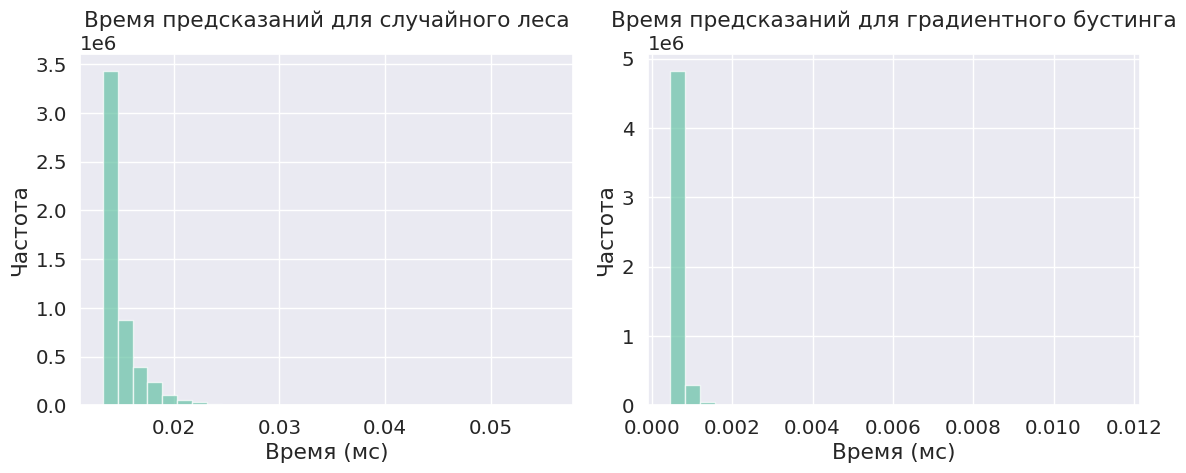

In [44]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(rf_prediction_times* 1000, bins=30, alpha=0.7, label='Random Forest')
plt.title('Время предсказаний для случайного леса')
plt.xlabel('Время (мс)')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(gb_prediction_times * 1000, bins=30, alpha=0.7, label='Gradient Boosting')
plt.title('Время предсказаний для градиентного бустинга')
plt.xlabel('Время (мс)')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Теперь сравним число деревьев и листьев

In [45]:
rf_tree_stats = [(tree.get_depth(), tree.get_n_leaves()) for tree in rf.estimators_]
rf_depths, rf_n_leaves = zip(*rf_tree_stats)

gb_tree_stats = [(tree[0].get_depth(), tree[0].get_n_leaves()) for tree in gb.estimators_]
gb_depths, gb_n_leaves = zip(*gb_tree_stats)

rf_avg_depth = np.mean(rf_depths)
rf_avg_n_leaves = np.mean(rf_n_leaves)
gb_avg_depth = np.mean(gb_depths)
gb_avg_n_leaves = np.mean(gb_n_leaves)

print(f"Средняя глубина деревьев в случайном лесу: {rf_avg_depth:.2f}")
print(f"Среднее количество листьев в случайном лесу: {rf_avg_n_leaves:.2f}")
print(f"Средняя глубина деревьев в градиентом бустинге: {gb_avg_depth:.2f}")
print(f"Среднее количество листьев в градиентном бустинге: {gb_avg_n_leaves:.2f}")

Средняя глубина деревьев в случайном лесу: 26.00
Среднее количество листьев в случайном лесу: 9303.89
Средняя глубина деревьев в градиентом бустинге: 5.00
Среднее количество листьев в градиентном бустинге: 28.40


Теперь гистограммы

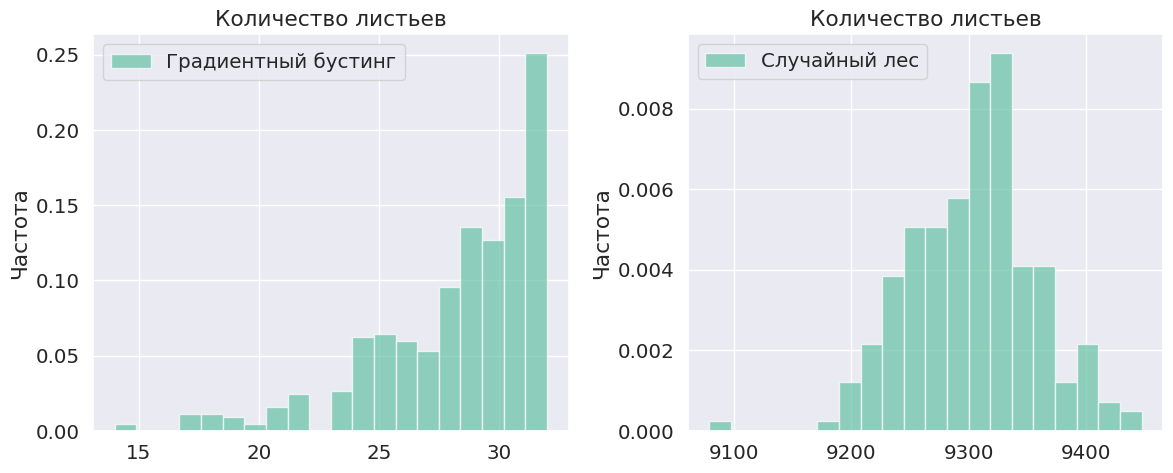

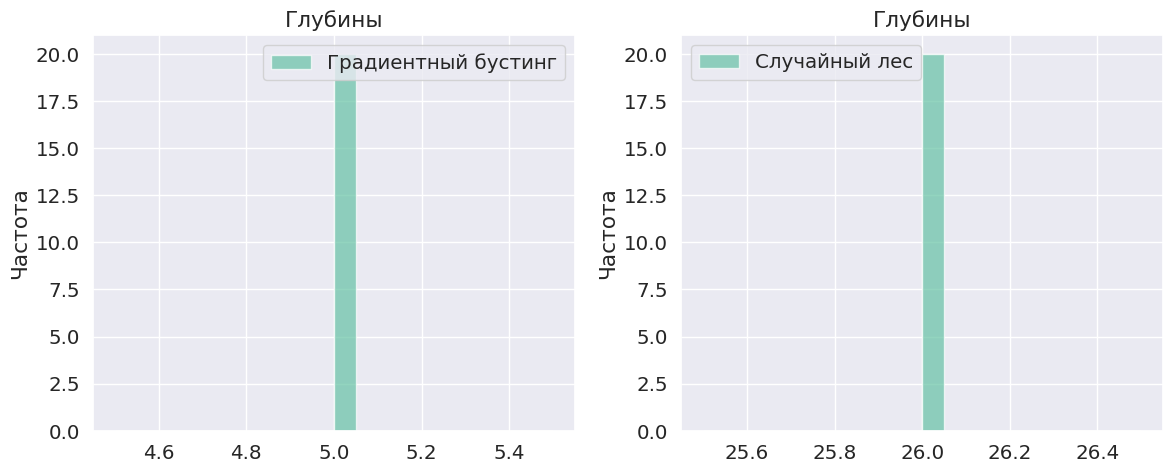

In [46]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(gb_n_leaves, alpha=0.7, bins=20, density=True,
         label='Градиентный бустинг')
plt.title('Количество листьев')
plt.ylabel('Частота')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(rf_n_leaves, alpha=0.7, bins=20, density=True,
         label='Случайный лес')
plt.title('Количество листьев')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(gb_depths, alpha=0.7, bins=20, density=True,
         label='Градиентный бустинг')
plt.title('Глубины')
plt.ylabel('Частота')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(rf_depths, alpha=0.7, bins=20, density=True,
         label='Случайный лес')
plt.title('Глубины')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()

**Итоговый результат сравнения (в тч с задачей 1)**

**Случайный лес:**

1) Требуется больше деревьев
2) Деревья могут строиться параллельно - обучаются быстрее
3) Устойчивость к переобучению

**Градиентный бустинг:**
1) Требуется меньшее число деревьев и менее глубоких (при достижении той же точности)
2) Деревья строятся строго последовательно - нельзя распараллелить процесс обучения - дольше обучается
3) Быстрее предсказывают
4) Сложнее подбирать гиперпараметры


#### 3. 

Выберите самый значимый признак согласно `feature_importances_`. Визуализируйте работу бустинга, обученного только на одном этом признаке.

Для этого рассмотрите процесс построения бустинга для первых 10 итераций. При визуализации требуется для каждой итерации нарисовать:
* предсказания новой базовой модели и выборку, на которой эта базовая модель обучается;
* предсказания текущей композиции и исходную обучающую выборку. 

Пример графиков смотрите в лекции в разделе бустинг в задаче регресии.

In [47]:
gb = GradientBoostingRegressor(n_estimators=gb_n_estimators, learning_rate=gb_learning_rate,
                                   max_depth=gb_max_depth, random_state=42)

gb.fit(X_train, y_train)

np.argmax(gb.feature_importances_)

np.int64(0)

То есть первый признак самый важный. Будем обучать по нему

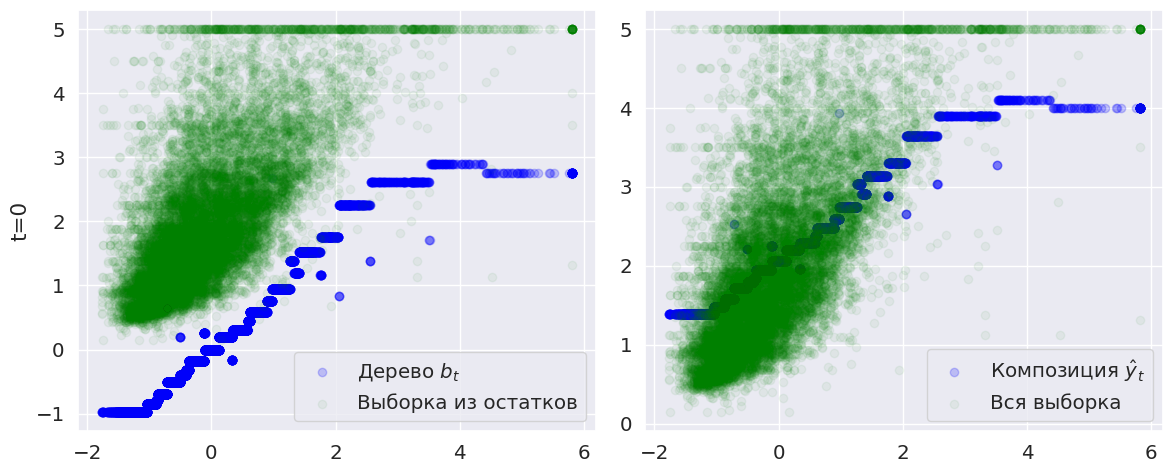

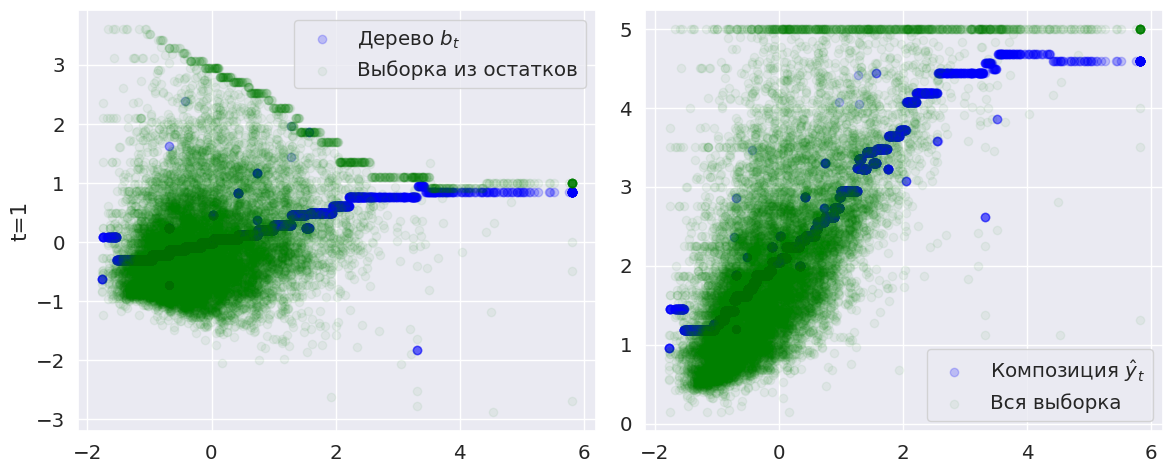

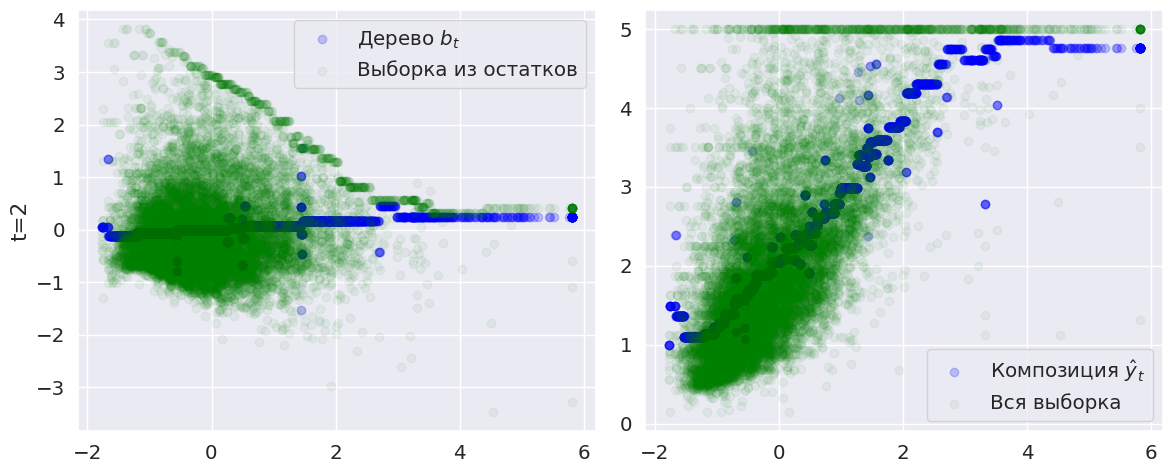

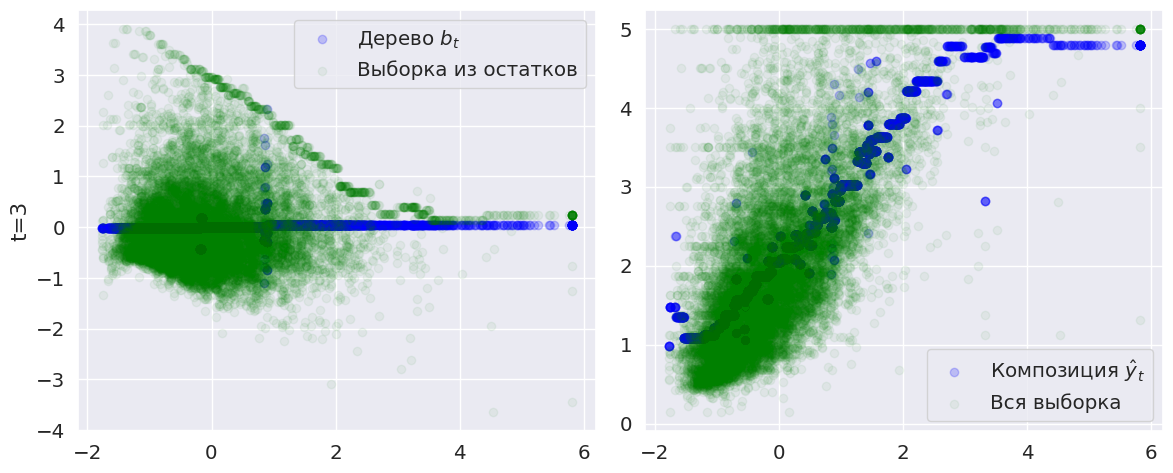

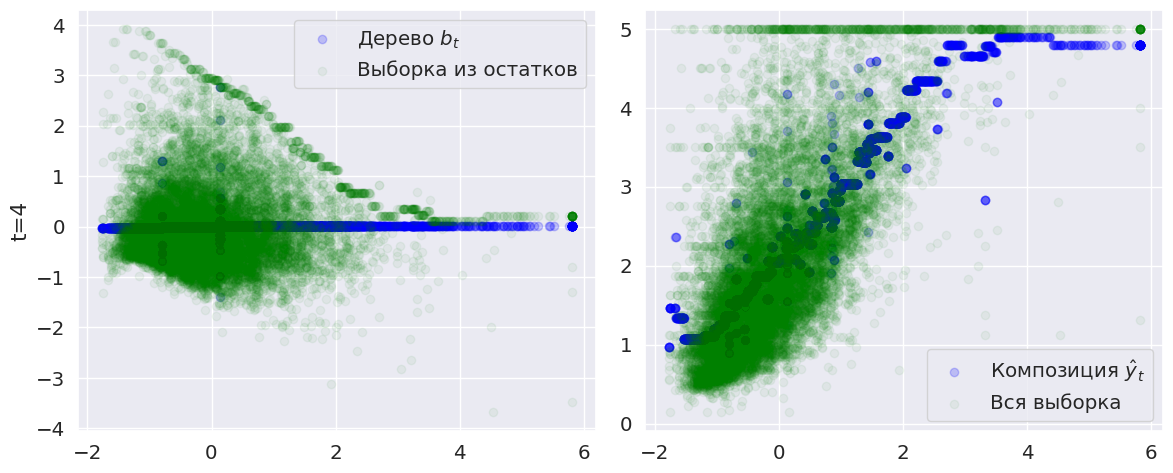

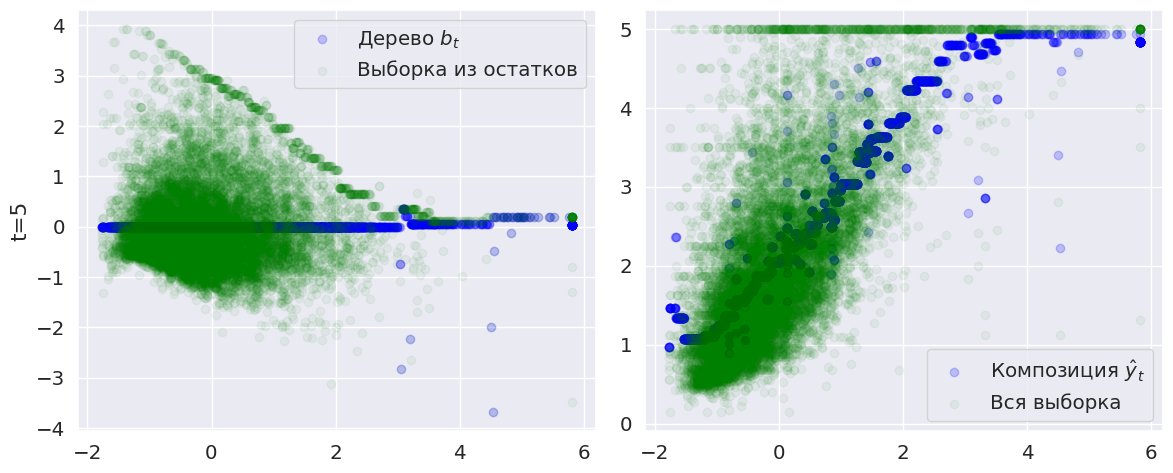

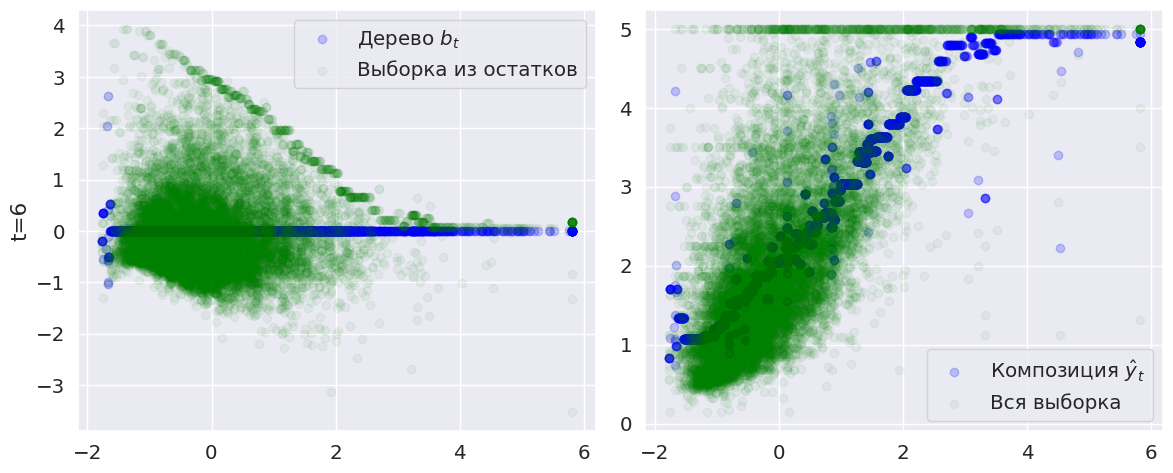

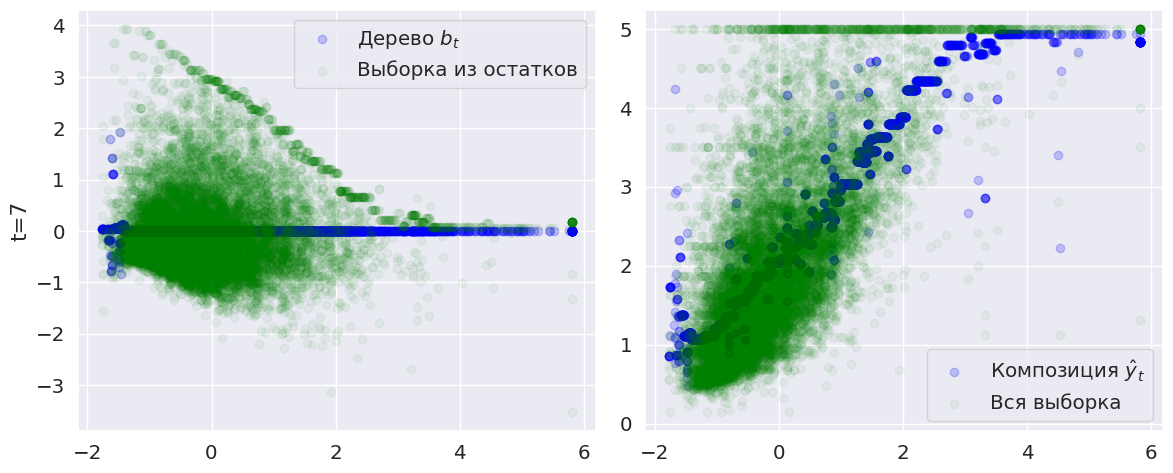

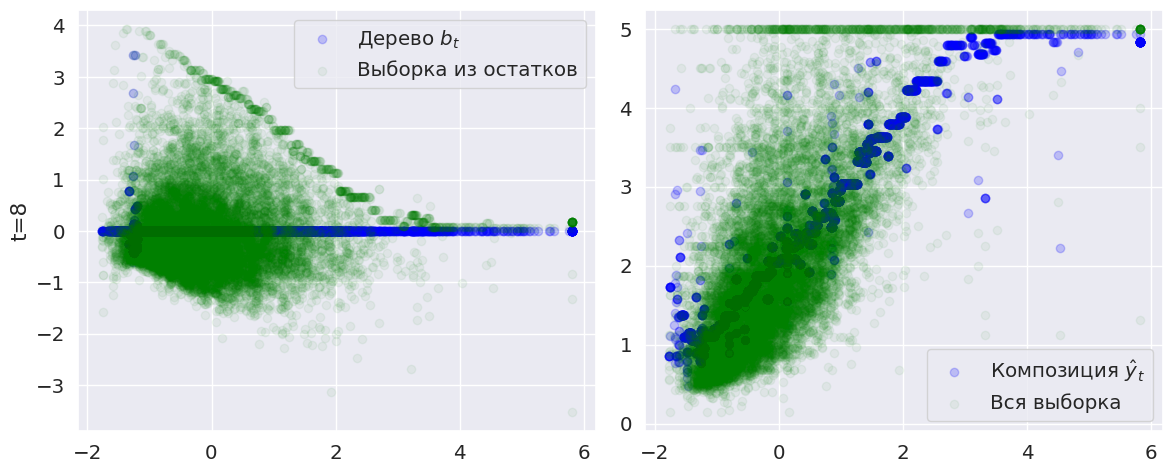

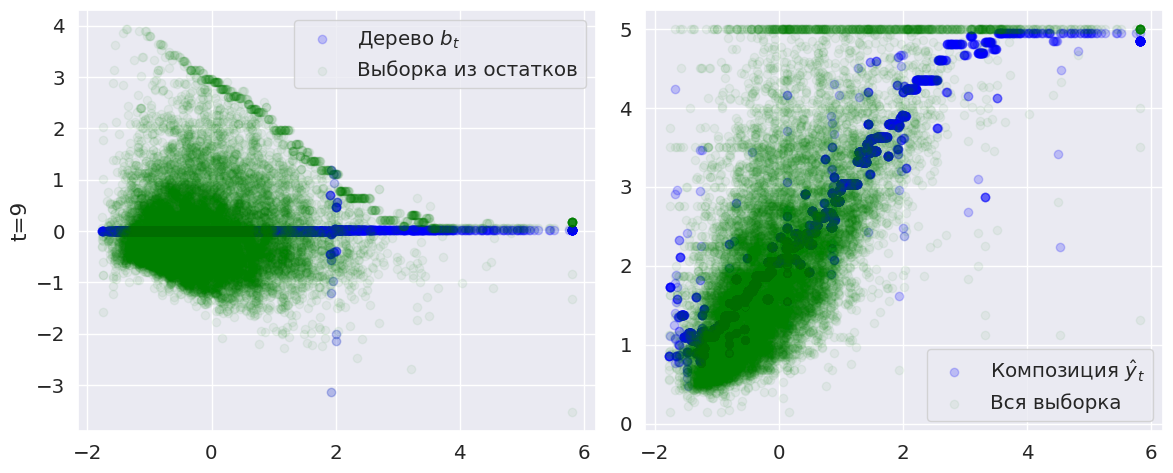

In [48]:
regressor = GradientBoostingRegressor(n_estimators=10,
                                      max_depth=5,
                                      learning_rate=0.7)
regressor.fit(X_train[:, 0].reshape(-1, 1), y_train)

staged_predictions = list(regressor.staged_predict(X_train[:, 0].reshape(-1, 1)))

current_pred = np.zeros(y_train.shape)

for i, estimator in enumerate(regressor.estimators_):

    new_model_pred = estimator[0].predict(X_train[:, 0].reshape(-1, 1))
    old_pred = np.copy(current_pred)
    current_pred = staged_predictions[i]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X_train[:, 0], new_model_pred, alpha=0.2,
                color='blue', label=r'Дерево $b_t$')
    plt.scatter(X_train[:, 0], y_train - old_pred, alpha=0.05,
                color='green', label='Выборка из остатков')
    plt.ylabel(f't={i}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(X_train[:, 0], current_pred, alpha=0.2, 
              color='blue', label=r'Композиция $\hat y_t$')
    plt.scatter(X_train[:, 0], y_train, alpha=0.05,
                color='green', label='Вся выборка')
    plt.legend()
    plt.tight_layout()
    plt.show()


Как получается выборка, на которой обучается новая базовая модель в данном случае и в общем случае? 

Очередная базовая модель обучается выборке на остатках предсказаний предыдущей итерации алгоритма.

В случае же стохастического градиентного бустинга, на каждом шаге сэмплируется случайная подвыборка из остатков, и обучение происходит уже на ней

#### 4.

Параметр `init` у класса `GradientBoostingRegressor` задает модель, выполняющую начальные предсказания, с которых стартует построение ансамбля. Какая начальная модель используется по умолчанию?

По умолчанию - DummyEstimator, предсказывающией среднее значение



Обучите градиентный бустинг на решающих деревьях, у которого в качестве инициализирующей модели используется линейная регрессия. Для этого в качестве параметра `init` передайте модель ридж-регрессии `Ridge`, которая должна быть инициализирована, но необучена. 

Подберите оптимальные гиперпараметры такой композиции. Как вы будете подбирать гиперпараметр ридж-регрессии? Улучшилось ли качество модели на тестовой выборке?

*Замечания.* 

1. Для настройки `alpha` в `Ridge`-модели внутри `GradientBoostingRegressor` вам может помочь метод `get_params()` у бустинга.
2. Не забывайте, что у бустинга тоже есть параметр `alpha`, не перепутайте их.

Сетка гиперпараметров (данные уже были стандартизированы в первом пункте)

In [54]:
from sklearn.linear_model import Ridge

gb_ridge = GradientBoostingRegressor(random_state=42)
param_grid = {
    'max_depth': np.arange(2, 11), 
    'learning_rate': np.linspace(0.1, 1, 5),
    'n_estimators': [500],
    'init': [Ridge()],
    'init__alpha': np.logspace(-7, 8, 20),
    'init__max_iter': [1500]
}

gb_gridsearch = RandomizedSearchCV(
    estimator=gb_ridge, 
    param_distributions=param_grid,
    scoring='neg_mean_squared_error',  # оптимизируемый скор
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=2,  # насколько часто печатать сообщения
    n_jobs=-1,  # кол-во параллельных процессов
    n_iter=60,  # кол-во итераций случайного выбора гиперпараметров
    random_state=0  # seed для фиксации генератора случайных чисел
)

Ищем оптимальные гиперпараметры

In [55]:
gb_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'init': [Ridge()],
                                        'init__alpha': array([1.00000000e-07, 6.15848211e-07, 3.79269019e-06, 2.33572147e-05,
       1.43844989e-04, 8.85866790e-04, 5.45559478e-03, 3.35981829e-02,
       2.06913808e-01, 1.27427499e+00, 7.84759970e+00, 4.83293024e+01,
       2.97635144e+02, 1.83298071e+03, 1.12883789e+04, 6.95192796e+04,
       4.28133240e+05, 2.63665090e+06, 1.62377674e+07, 1.00000000e+08]),
                                        'init__max_iter': [1500],
                                        'learning_rate': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': [500]},
                   random_state=0, scoring='neg_mean_squared_error', verbose=2)

Лучше параметры

In [56]:
def round_params(gridsearch, precision=1):
    list_keys = list(gridsearch.best_params_.keys())
    print("Лучшие параметры:")

    for key in list_keys:
        if isinstance(gridsearch.best_params_[key], (int, float)):
            value = round(gridsearch.best_params_[key], precision)
        else:
            value = gridsearch.best_params_[key]
        print(f"{key:<{15}}: {value}")
    return

round_params(gb_gridsearch, 1)

Лучшие параметры:
n_estimators   : 500
max_depth      : 7
learning_rate  : 0.1
init__max_iter : 1500
init__alpha    : 11288.4
init           : Ridge()


MSE для лучшей модели с Ridge:

In [57]:
predictions = gb_gridsearch.best_estimator_.predict(X_test)
print('Ridge best: {:.3f}'.format(mse(y_test, predictions)))

gb = GradientBoostingRegressor(n_estimators=gb_n_estimators, learning_rate=gb_learning_rate,
                                   max_depth=gb_max_depth)
gb.fit(X_train, y_train)
predictions = gb.predict(X_test)
print('Non-Ridge best: {:.3f}'.format(mse(y_test, predictions)))

Ridge best: 0.215
Non-Ridge best: 0.224


**Таким образом, использование Ridge чуть улучшает работу модели**

Есть смысл в качестве первой модели брать какие-то более сложные вещи, чем просто Dummy Estimator - увеличивается предсказательная возможность модели


#### 5. 

Рассмотрим модели смеси градиентного бустинга $\widehat{y}_{gb}$ и случайного леса $\widehat{y}_{rf}$ с оптимальными гиперпараметрами, подобранными ранее, в виде
$$\widehat{y}(x) = w \widehat{y}_{gb}(x) +  (1-w) \widehat{y}_{rf}(x),$$
где $w \in [0, 1]$ &mdash; коэффициент усреднения. Подберите оптимальное значение гиперпараметра $w$ и выведите его. Удалось ли добиться улучшения качества на тестовой выборке?

In [59]:
rf = RandomForestRegressor(n_estimators=rf_n_estimators,
                               max_depth=rf_max_depth, random_state=42)
gb = GradientBoostingRegressor(n_estimators=gb_n_estimators, learning_rate=gb_learning_rate,
                                   max_depth=gb_max_depth, random_state=42)

gb.fit(X_train, y_train)
rf.fit(X_train, y_train)

gb_pred = gb.predict(X_test)
rf_pred = rf.predict(X_test)

w_values = np.linspace(0, 1, 100)
mse_values = []

for w in w_values:
    mse_values.append(mse(y_test, w * gb_pred + (1 - w) * rf_pred))

optimal_w = w_values[np.argmin(mse_values)]
best_mse = min(mse_values)

print(f"Оптимальное значение w: {optimal_w:.3f}")
print(f"MSE на тестовой выборке с использованием смеси: {best_mse:.6f}")

mse_gb = mse(y_test, gb_pred)
mse_rf = mse(y_test, rf_pred)

print(f"MSE градиентного бустинга: {mse_gb:.6f}")
print(f"MSE случайного леса: {mse_rf:.6f}")

Оптимальное значение w: 0.808
MSE на тестовой выборке с использованием смеси: 0.221617
MSE градиентного бустинга: 0.223530
MSE случайного леса: 0.257760


**Хоть случайный лес дает худший результат по сравнению с градиентным бустингом, усреднение ответов градиентного бустинга и случайного леса дает лучший результат, чем любой из них по отдельности. При этом параметр $w$ ближе к 1, что логично, ведь градиентный бустинг оказался точнее. Усреднение улучшает результат за счет использования сразу обоих методов, модели дополнют друг друга**

**6.**

Сделайте итоговые выводы.

И случайный лес, и градиентный бустинг - сильные инструменты машиного обучения.

Каждый из них хорошо работает с многоразмерными сложными датасетами, а также они способны моделировать сложные зависимости

Градиентный бустинг более склонен к переобучению на небольших данных, либо при плохом выборе гиперпараметров. Случайный лес же менее требовательный к выбору гиперпараметрво

